In [38]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
from recommender import RecommendationEngine
from utils import *
from operator import itemgetter

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [2]:
# Loading necessary csvs into Pandas
data_folder = "/Users/alex/Workspace/Datasets/OlistEcommercePublicDataset"

df_names = [
    "orders_df",
    "reviews_df",
    "products_df",
    "order_items_df",
    "customer_df",
    "cat_name_translation",
]
df_files = [
    "olist_orders_dataset.csv",
    "olist_order_reviews_dataset.csv",
    "olist_products_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_customers_dataset.csv",
    "product_category_name_translation.csv",
]

# Loading dataframes
dataframes = preprocess_dataframes(read_dataframes(df_names, df_files, data_folder))

# Filtering final dataframe by most active users and bought items
final_df = filter_dataframe(
    join_dataframes(dataframes), item_number=500, user_number=1000
)

# Loading translation dictionary [Portugues -> English]
translate_dict = get_translation_dict(dataframes["cat_name_translation"])

# Initializing our custom recommendation engine
recommendationengine = RecommendationEngine(
    final_df, dataframes["products_df"], dataframes["order_items_df"], translate_dict
)


In [3]:
time_df = final_df.drop_duplicates(subset=['customer_unique_id', 'product_id']).reset_index(drop=True)
time_df['order_purchase_timestamp'] = pd.to_datetime(time_df['order_purchase_timestamp'])
time_df.head()

,order_purchase_timestamp,customer_unique_id,product_id,price,review_score,count
0,2017-09-19 22:17:15,7973a6ba9c81ecaeb3d628c33c7c7c48,7c1bd920dbdf22470b68bde975dd3ccf,58.99,5,3
1,2018-05-11 16:35:19,831a032a3327e2b8325faf9d37953870,216bb0e0cd43ffd832e0973d35e0377e,45.00,5,6
2,2017-07-31 20:47:50,cb2d00950f18d7d8f7fcfc8cc3a173b7,389d119b48cf3043d311335e499d9c6b,59.90,3,3
3,2018-04-16 14:21:02,f8f6ed51ded0d4757a6153f5ce0f8906,10717ff440b2320081989126e858b220,138.00,4,3
4,2018-02-12 17:33:54,bf257f507db19138f5bc4065313c1f87,e53e557d5a159f5aa2c5e995dfdf244b,74.90,5,3


In [4]:
df_2017 = time_df[time_df['order_purchase_timestamp'].dt.year == 2017]
df_2018 = time_df[time_df['order_purchase_timestamp'].dt.year == 2018]
display(df_2017.head())
display(df_2018.head())

,order_purchase_timestamp,customer_unique_id,product_id,price,review_score,count
0,2017-09-19 22:17:15,7973a6ba9c81ecaeb3d628c33c7c7c48,7c1bd920dbdf22470b68bde975dd3ccf,58.99,5,3
2,2017-07-31 20:47:50,cb2d00950f18d7d8f7fcfc8cc3a173b7,389d119b48cf3043d311335e499d9c6b,59.90,3,3
5,2017-04-03 19:07:32,3702265e16e5246cff7462ea675f6d90,c403e106353e1aa40efe783ecb39ed7a,34.90,4,4
7,2017-03-09 16:43:40,563bf685b8426233585285851fa03881,ecbe1ef7e2903ff8b1d704ba78fa264d,99.00,5,4
8,2017-11-24 19:58:16,09c361fed7245568f0f104496ed4f92f,a19b6951c75da43aad691622dd2f6abe,32.99,5,3


,order_purchase_timestamp,customer_unique_id,product_id,price,review_score,count
1,2018-05-11 16:35:19,831a032a3327e2b8325faf9d37953870,216bb0e0cd43ffd832e0973d35e0377e,45.00,5,6
3,2018-04-16 14:21:02,f8f6ed51ded0d4757a6153f5ce0f8906,10717ff440b2320081989126e858b220,138.00,4,3
4,2018-02-12 17:33:54,bf257f507db19138f5bc4065313c1f87,e53e557d5a159f5aa2c5e995dfdf244b,74.90,5,3
6,2018-03-25 16:43:56,c375736396906dff8414217e02c45661,9f1c3e71d56894398a42b050b07f1baa,11.87,3,3
10,2018-02-18 20:42:53,b08b68bac767c3269e827f822d308182,727a46f0b58a9ef165af9f7ebcfebfa9,19.49,1,5


In [5]:
monthly_profit_2017 = df_2017.groupby(df_2017['order_purchase_timestamp'].dt.month)['price'].sum()
monthly_profit_2018 = df_2018.groupby(df_2018['order_purchase_timestamp'].dt.month)['price'].sum()

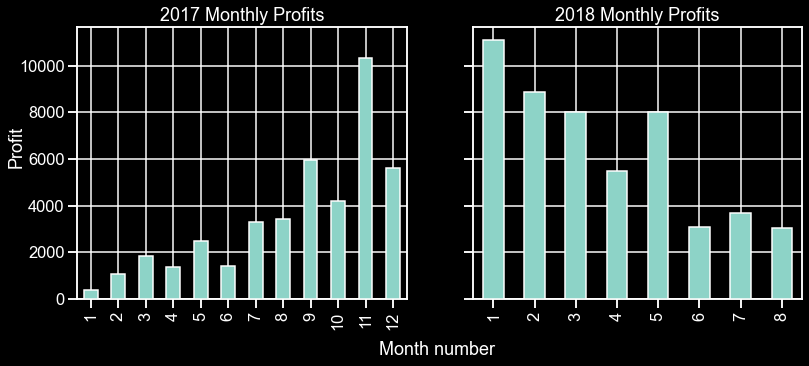

In [6]:
f, ax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(13, 5))

monthly_profit_2017.plot.bar(ax = ax[0], grid=True, zorder=3)
ax[0].set_title('2017 Monthly Profits')
ax[0].set_xlabel('')


monthly_profit_2018.plot.bar(ax = ax[1], grid=True, zorder=3)
ax[1].set_title('2018 Monthly Profits')

f.text(0.06, 0.5, 'Profit', ha='center', rotation=90);
f.text(0.51, -0.03, 'Month number', ha='center');
ax[1].set_xlabel('')

plt.show()

In [49]:
id_to_idx = {}
for customer_idx in range(0, 999):
    recos, customer_id = recommendationengine.get_recommendation(customer_idx=customer_idx, nr_of_items=2, cluster=True)
    id_to_idx[customer_id] = customer_idx

In [50]:
users_2017 = {}
users_2018 = {}

for month in sorted(df_2017['order_purchase_timestamp'].dt.month.unique()):
    users_2017[month] = df_2017[df_2017['order_purchase_timestamp'].dt.month == month]['customer_unique_id'].values
for month in sorted(df_2018['order_purchase_timestamp'].dt.month.unique()):
    users_2018[month] = df_2018[df_2018['order_purchase_timestamp'].dt.month == month]['customer_unique_id'].values

In [126]:
increased_monthly_profit_2017 = monthly_profit_2017.copy()

for month in sorted(df_2017['order_purchase_timestamp'].dt.month.unique()):
    print(f"Month: {month}")
    ids_2017 = users_2017[month]
    try:
        idx_2017 = itemgetter(*ids_2017)(id_to_idx)
    except KeyError as e:
        print(e.args[0])
        ids_2017 = list(ids_2017)
        ids_2017.remove(e.args[0])
        idx_2017 = itemgetter(*ids_2017)(id_to_idx)

    item_prices = []

    for customer_idx in idx_2017:
        recos, customer_id = recommendationengine.get_recommendation(customer_idx=customer_idx, nr_of_items=2, cluster=True)
        
        if recos.empty:
            recos, customer_id = recommendationengine.get_recommendation(customer_idx=customer_idx, nr_of_items=2, cluster=False)

        item_prices.append(recos.iloc[0]['price'])

    print(f"Increasing by {sum(item_prices)}")
    increased_monthly_profit_2017[month] += sum(item_prices)

Month: 1
Increasing by 92.43923897581791
Month: 2
Increasing by 329.9195469582189
Month: 3
Increasing by 1096.1672020413237
Month: 4
Increasing by 1194.0979386213726
Month: 5
ff9ff869636c26565ded16038be5fa7d
Increasing by 1531.1678354501657
Month: 6
Increasing by 1146.1083083073502
Month: 7
Increasing by 2775.888290803632
Month: 8
Increasing by 2482.077248180801
Month: 9
Increasing by 5139.8748227808765
Month: 10
Increasing by 3446.8956524984196
Month: 11
Increasing by 10237.000360957805
Month: 12
Increasing by 5292.5645033811


<AxesSubplot:xlabel='order_purchase_timestamp'>

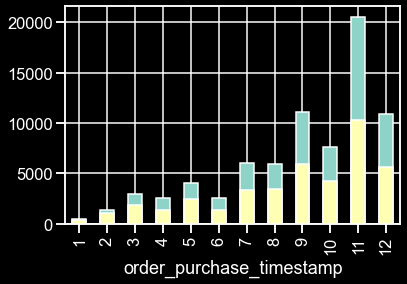

In [132]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
axx = increased_monthly_profit_2017.plot.bar(grid=True, zorder=3, color=colors[0])
monthly_profit_2017.plot.bar(ax = axx, grid=True, zorder=3, color=colors[1])